In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

import jax
import jax.numpy as jnp

In [2]:
x = np.linspace(0, 10*np.pi, num=1000)
e = np.random.normal(scale=10.0, size=x.size)
y = 65.0 + 1.8*x + 40*np.cos(x) + e

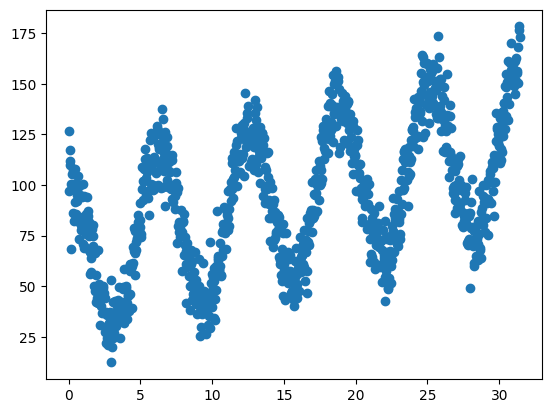

In [3]:
plt.scatter(x, y)

### Working with gradients in PyTorch

In [4]:
xt, yt = torch.tensor(x), torch.tensor(y)

learning_rate = 1e-2

w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(1.0, requires_grad=True)

In [5]:
model = lambda x: w*x + b
loss_fn = lambda pred, y: torch.mean((pred - y)**2)

In [6]:
prediction = model(xt)
loss = loss_fn(prediction, yt)

In [7]:
loss.backward()

with torch.no_grad():
    w -= learning_rate * w.grad
    b -= learning_rate * b.grad

    w.grad.zero_()
    b.grad.zero_()

In [8]:
w, b

(tensor(26.4206, requires_grad=True), tensor(2.5296, requires_grad=True))

### Working with gradients in JAX

In [9]:
xt, yt = jnp.array(x), jnp.array(y)
learning_rate = 1e-2
model_parameters = jnp.array([1.0, 1.0])

In [10]:
def model(theta, x):
    w, b = theta
    return w*x + b

def loss_fn(model_parameters, x, y):
    prediction = model(model_parameters, x)
    return jnp.mean((prediction - y)**2)

In [11]:
grads_fn = jax.grad(loss_fn)
grads = grads_fn(model_parameters, xt, yt)
model_parameters -= learning_rate * grads

In [12]:
model_parameters

Array([26.420559 ,  2.5296082], dtype=float32)

#### Differentitating w.r.t. the first parameter

In [13]:
def dist(order, x, y):
    return jnp.power(jnp.sum(jnp.abs(x-y)**order), 1.0/order)

In [14]:
dist_d_x = jax.grad(dist, argnums=1)

In [15]:
dist_d_x(1, jnp.array([1.0, 1.0, 1.0]), jnp.array([2.0, 2.0, 2.0]))

Array([-1., -1., -1.], dtype=float32)

#### Differentiation w.r.t. multiple parameters

In [16]:
dist_d_xy = jax.grad(dist, argnums=(1,2))

In [17]:
dist_d_xy(1, jnp.array([1.0, 1.0, 1.0]), jnp.array([2.0, 2.0, 2.0]))

(Array([-1., -1., -1.], dtype=float32), Array([1., 1., 1.], dtype=float32))

#### Differentiating with respect to dicts

In [18]:
model_parameters = {
    'w': jnp.array(1.0),
    'b': jnp.array(1.0)
}

In [19]:
def model(param_dict, x):
    w, b = param_dict['w'], param_dict['b']
    return w*x + b

def loss_fn(model_parameters, x, y):
    prediction = model(model_parameters, x)
    return jnp.mean((prediction - y)**2)

In [20]:
grads_fn = jax.grad(loss_fn)
grads = grads_fn(model_parameters, xt, yt)

In [21]:
grads

{'b': Array(-152.96085, dtype=float32, weak_type=True),
 'w': Array(-2542.056, dtype=float32, weak_type=True)}

#### Dealing with auxiliary data

In [22]:
model_parameters = jnp.array([1., 1.])

In [23]:
def model(theta, x):
    w, b = theta
    return w*x + b

def loss_fn(model_parameters, x, y):
    prediction = model(model_parameters, x)
    return jnp.mean((prediction - y)**2), prediction

In [24]:
grads_fn = jax.grad(loss_fn, has_aux=True)
grads, preds = grads_fn(model_parameters, xt, yt)

In [25]:
model_parameters -= learning_rate * grads
model_parameters

Array([26.420559 ,  2.5296082], dtype=float32)

#### Gradients, values, and auxiliary data

In [26]:
model_parameters = jnp.array([1., 1.])

def model(theta, x):
    w, b = theta
    return w*x + b

def loss_fn(model_parameters, x, y):
    prediction = model(model_parameters, x)
    return jnp.mean((prediction - y)**2), prediction

In [27]:
grads_fn = jax.value_and_grad(loss_fn, has_aux=True)
(loss, preds), grads = grads_fn(model_parameters, xt, yt)

In [28]:
model_parameters -= learning_rate * grads
model_parameters

Array([26.420559 ,  2.5296082], dtype=float32)

### Higher-order derivatives

In [29]:
f = lambda x: x**4 + 12*x + 1/x

f_d1 = jax.grad(f)
f_d2 = jax.grad(f_d1)
f_d3 = jax.grad(f_d2)

In [30]:
x = 11.0

print(f_d1(x))
print(f_d2(x))
print(f_d3(x))

5335.9917
1452.0015
263.9996


In [31]:
def f(x):
    return x**3 + 12*x + 7*x*jnp.sin(x)

In [32]:
x = np.linspace(-10, 10, num=500)

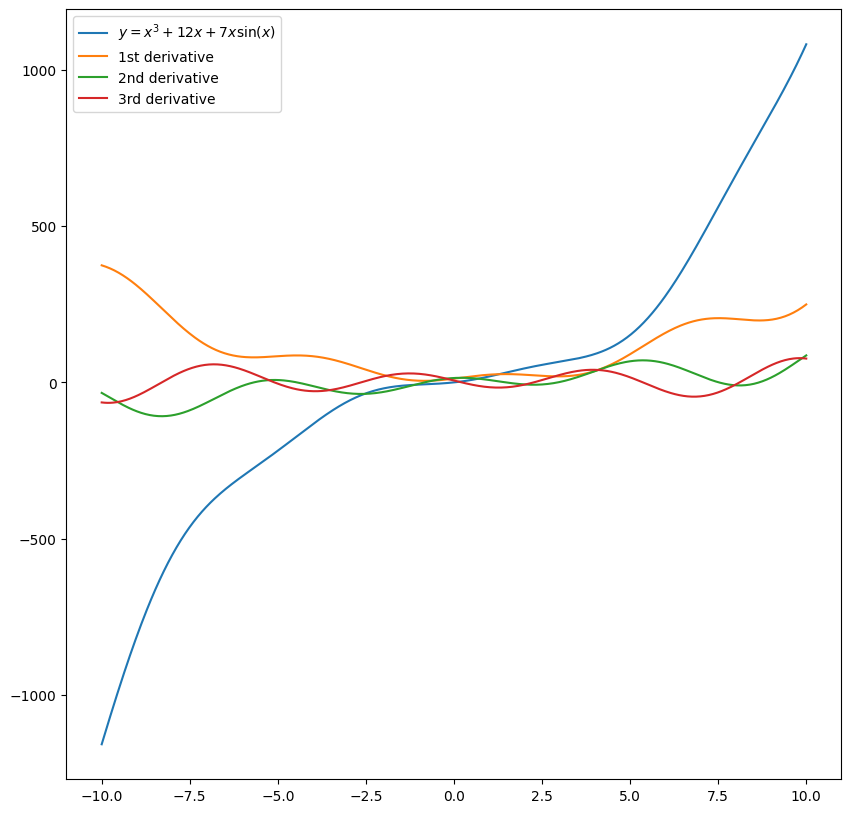

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x, f(x), label=r"$y = x^3 + 12x + 7x\sin(x)$")

df = f
for d in range(3):
    df = jax.grad(df)
    ax.plot(x, jax.vmap(df)(x),
        label=f"{['1st', '2nd', '3rd'][d]} derivative")
    ax.legend()

### Vector-valued functions

In [34]:
def f(x):
    return [
        x[0]**2 + x[1]**2 - x[1]*x[2],
        x[0]**2 - x[1]**2 + 3*x[0]*x[2]
    ]

In [35]:
print(jax.jacrev(f)(jnp.array([3.0, 4.0, 5.0])))
print(jax.jacfwd(f)(jnp.array([3.0, 4.0, 5.0])))

[Array([ 6.,  3., -4.], dtype=float32), Array([21., -8.,  9.], dtype=float32)]
[Array([ 6.,  3., -4.], dtype=float32), Array([21., -8.,  9.], dtype=float32)]


In [36]:
%timeit -n 100 jax.jacrev(f)(jnp.array([3.0, 4.0, 5.0]))

13.5 ms ± 174 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%timeit -n 100 jax.jacfwd(f)(jnp.array([3.0, 4.0, 5.0]))

6.61 ms ± 68.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Hessian

In [38]:
def f(x):
    return x[0]**2 - x[1]**2 + 3*x[0]*x[2]

In [39]:
jax.hessian(f)(jnp.array([3.0, 4.0, 5.0]))

Array([[ 2.,  0.,  3.],
       [ 0., -2.,  0.],
       [ 3.,  0.,  0.]], dtype=float32)

In [40]:
jax.jacfwd(jax.grad(f))(jnp.array([3.0, 4.0, 5.0]))

Array([[ 2.,  0.,  3.],
       [ 0., -2.,  0.],
       [ 3.,  0.,  0.]], dtype=float32)